In [27]:
import numpy as np
import pandas as pd
from scipy import stats
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nasdaq_historical = yf.download('^NDX', start='1990-01-01', end='2024-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
MCD = yf.Ticker("MCD")

In [4]:
csd_df = pd.read_csv("datasets/cds.csv", index_col='Date', parse_dates=True)

In [5]:
print(pd.unique(csd_df['Company']))

['Agilent Technologies Inc' 'Anglo American PLC' 'Apple Inc' 'ABB Ltd'
 'AbbVie Inc' 'AmerisourceBergen Corp' 'Abertis Infraestructuras SA'
 'Anheuser Busch InBev SA NV' 'Abbott Laboratories' 'Barrick Gold Corp'
 'Credit Agricole' 'ACEA SpA' 'Accor SA' 'Adecco Group AG'
 'ADLER Real Estate AG' 'Archer-Daniels-Midland Co'
 'Koninklijke Ahold Delhaize NV' 'Automatic Data Processing Inc'
 'adidas AG' 'Aegon NV' 'The AES Corporation' 'Aetna Inc'
 'American Financial Group Inc' 'African Export-Import Bank'
 'Avangrid Inc' 'Agricultural Bank of China Ltd' 'Ageas' 'Air Liquide SA'
 'American International Group Inc' 'Airbus SE' 'Akzo Nobel NV'
 'Allstate Corp' 'Alliander NV' 'Ally Financial Inc' 'Alstom SA'
 'Alpha Bank AE' 'Allianz SE' 'Applied Materials Inc' 'Amgen Inc'
 'Ameriprise Financial Inc' 'American Tower Corp'
 'America Movil SAB de CV' 'Amazon.com Inc' 'AutoNation Inc'
 'AngloGold Ashanti' 'Anthem Inc' 'Australia   New Zealand Banking'
 'Air Products   Chemicals Inc' 'FCC Aqualia 

In [44]:
mcdonalds = csd_df[csd_df['Company'] == "McDonald's Corp"]
mcdonalds_historical = yf.download('MCD', start=mcdonalds.index.min().strftime('%Y-%m-%d'), end=mcdonalds.index.max().strftime('%Y-%m-%d'))
mcdonalds = pd.merge(mcdonalds, mcdonalds_historical.droplevel(1, axis=1), left_index=True, right_index=True)
mcdonalds['log_returns'] = np.log(mcdonalds['Adj Close'] / mcdonalds['Adj Close'].shift(1))

[*********************100%***********************]  1 of 1 completed


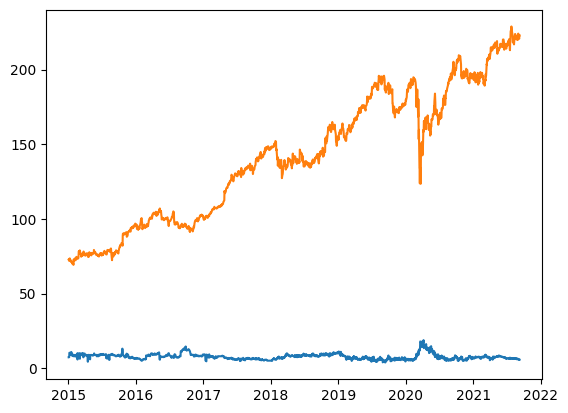

In [41]:
plt.plot(mcdonalds['PX1'])
plt.plot(mcdonalds['Adj Close'])

In [43]:
def blackscholes(S0, K, T, r, sigma):
    """
    Price of a European call in the Black-Scholes model.
    """
    d1 = (np.log(S0)-np.log(K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    return S0*norm.cdf(d1)-np.exp(-r*T)*K*norm.cdf(d2)

In [45]:
# calc the daily volatility of returns and use as a super naive volatility estimate
daily_vol = np.std(mcdonalds['log_returns'].dropna())
annualized_vol_naive = daily_vol * np.sqrt(252)

In [46]:
mcdonalds_bubble = mcdonalds['Adj Close']
mcdonalds_bubble_full = pd.DataFrame(mcdonalds_bubble)

# just used generic values to show
mcdonalds_bubble_full['K'] = mcdonalds_bubble_full['Adj Close']
mcdonalds_bubble_full['T'] = 1
mcdonalds_bubble_full['Rf'] = 0.05 
mcdonalds_bubble_full['sigma'] = annualized_vol_naive

In [47]:
bs_call_prices = []
for index, row in mcdonalds_bubble_full.iterrows():
    S0 = row['Adj Close']
    K = row['K']
    T = row['T']
    r = row['Rf']
    sigma = row['sigma']

    bs_price = blackscholes(S0, K, T, r, sigma)
    bs_call_prices.append(bs_price)

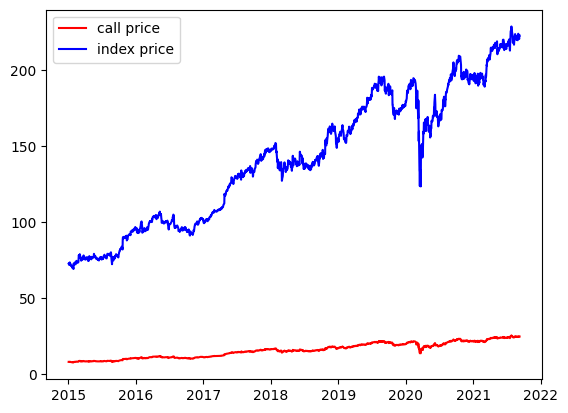

In [48]:
plt.plot(mcdonalds_bubble_full.index, bs_call_prices, color='r', label='call price')
plt.plot(mcdonalds_bubble_full['Adj Close'], color='b', label='index price')
plt.legend()

In [51]:
stats.pearsonr(bs_call_prices, mcdonalds_bubble_full['Adj Close'])

PearsonRResult(statistic=0.9999999999999989, pvalue=0.0)

In [52]:
mcdonalds_bubble_full

,Adj Close,K,T,Rf,sigma
Date,,,,,
2015-01-02,72.753845,72.753845,1,0.05,0.218209
2015-01-05,71.950348,71.950348,1,0.05,0.218209
2015-01-06,72.082954,72.082954,1,0.05,0.218209
2015-01-07,73.338959,73.338959,1,0.05,0.218209
2015-01-08,73.611992,73.611992,1,0.05,0.218209
...,...,...,...,...,...
2021-09-02,224.098297,224.098297,1,0.05,0.218209
2021-09-03,223.117340,223.117340,1,0.05,0.218209
2021-09-07,220.660263,220.660263,1,0.05,0.218209
